<a href="http://esprit.tn"><img src = "https://upload.wikimedia.org/wikipedia/commons/f/ff/Logo_ESPRIT_Ariana.jpg" width = 300, align = "center"></a>



<h1 align=center><font size = 5>Lab 8: Supervised learning - Decision Trees </font></h1>

Estimated duration: 60 min

## I.Goal: 

In this lab, you will learn to design a machine learning model using a popular algorithm: Decision Tree. You will use this classification algorithm to build an IDS model from KDD-99 benchmark. Then you use the trained decision tree to predict the class of a unknown patient, or to find a proper drug for a new patient.

In [19]:
import pandas as pnd
import numpy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import train_test_split
import  sklearn.tree as tr

## II. Loading data: 

In [2]:
import datetime
t=datetime.datetime.now()
print(datetime.datetime.now()- t)

def init_chrono():
    return datetime.datetime.now()

def elapsed_time(t):
    if t:
        delta = init_chrono() - t
        print ('Elapsed time', delta)
        return delta 
    
# test
t = init_chrono()
elapsed_time(t)

0:00:00.000074
Elapsed time 0:00:00.000030


datetime.timedelta(microseconds=30)

In [18]:
# Must declare data_dir as the directory of training and test files
#data_dir="./datasets/KDD-CUP-99/"
t = init_chrono()
#data_dir="./"
#data_dir="/home/hadoop/Documents/Teaching_18/esprit/data/KDD/"
data_dir="./"
raw_data_filename = data_dir + "new_dataset.csv"

print("Loading raw data")

#raw_data = pnd.read_csv(raw_data_filename, header=None)
dataset = pnd.read_csv(raw_data_filename, index_col=0)
elapsed_time(t)
dataset.head()

Loading raw data
Elapsed time 0:00:02.475836


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [12]:
dataset.shape

(494021, 42)

In [5]:
print(dataset.dtypes)
print(dataset.columns)

Unnamed: 0                       int64
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate              

In [13]:
dataset.head()
dataset['class'].head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: class, dtype: object

## III. Data pre-processing: 

In [14]:
class_tags = dataset['class'].unique()
class_dist_labels = dataset['class'].value_counts()

In [86]:
print ("Transforming data")
t=init_chrono()
# Categorize columns: "protocol", "service", "flag", "attack_type"
dataset['protocol_type'], protocols= pnd.factorize(dataset['protocol_type'])
dataset['service'], services = pnd.factorize(dataset['service'])
dataset['flag'], flags    = pnd.factorize(dataset['flag'])
dataset['class'], attacks = pnd.factorize(dataset['class'])
print(protocols, services, flags, attacks)
elapsed_time(t)

Transforming data
Int64Index([0, 1, 2], dtype='int64') Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
           dtype='int64') Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64') Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22],
           dtype='int64')
Elapsed time 0:00:00.027433


datetime.timedelta(microseconds=27433)

In [84]:
def object_to_scalar(df):
    for e in df.dtypes.items():
        if (e[1] == 'O'):
            df[e[0]], _ = pnd.factorize(df[e[0]])

object_to_scalar(dataset)

In [34]:
dataset['service'].head()

0    0
1    0
2    0
3    0
4    0
Name: service, dtype: int64

In [40]:
# separate features (columns 1..40) and label (column 41)
features = dataset.iloc[:,:dataset.shape[1]-1]
labels = dataset.iloc[:,dataset.shape[1]-1:]

In [41]:
Y = labels.values.ravel() # this becomes a 'horizontal' array

In [36]:
class_dist_id = dataset['class'].value_counts()

###  Preparing train and test dataset: 

In [37]:
from sklearn.model_selection import train_test_split

In [87]:
t = init_chrono()
# Separate data in train set and test set
X = pnd.DataFrame(features)
# create training and testing vars
# Note: train_size + test_size < 1.0 means we are subsampling
# Use small numbers for slow classifiers, as KNN, Radius, SVC,...
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2)
print ("X_train, y_train:", X_train.shape, y_train.shape)
print ("X_test, y_test:", X_test.shape, y_test.shape)
elapsed_time(t)

X_train, y_train: (395216, 41) (395216,)
X_test, y_test: (98805, 41) (98805,)
Elapsed time 0:00:00.240497


datetime.timedelta(microseconds=240497)

## IV. Building a classifier instance: the model  

In [88]:
# Training, choose model by commenting/uncommenting clf=
t= init_chrono()
clf = None
clf = DecisionTreeClassifier(criterion='entropy', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             random_state=None,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             class_weight=None,
                             presort=False)
print("Training model")

trained_model = clf.fit(X_train, y_train)
elapsed_time(t)

Training model
Elapsed time 0:00:01.302946


datetime.timedelta(seconds=1, microseconds=302946)

## V. Training the model:

In [79]:
t = init_chrono()
print("Training model")
trained_model = clf.fit(X_train, y_train)
elapsed_time(t)

Training model
Elapsed time 0:00:01.317070


datetime.timedelta(seconds=1, microseconds=317070)

Discovering ***decison tree*** main params: 

In [49]:
#help(clf)

## VI. Using the trained model: making predictions 

In [91]:

# Predicting
print ("Predicting using the test set ")
y_pred = clf.predict(X_test)
y_pred1 = clf.predict(X_train)
print(y_pred.shape)
print(y_pred[:10])
print(y_pred1[:10])

Predicting using the test set 
(98805,)
[4 5 0 5 5 5 5 5 5 5]
[4 5 5 5 4 0 0 5 5 5]


## VII. Model evaluation 

Accuracy on both training and test sets 

In [92]:
print ("Training Score:", trained_model.score(X_train, y_train))
print ("Test_Score: ", trained_model.score(X_test, y_test))

Training Score: 1.0
Test_Score:  0.9997166135317038


Since we are adressing a multi-class problem it's better to assess the classifier on each class using  ***f1_score***:

In [94]:
from sklearn.metrics import f1_score
print('By_class:',f1_score(y_test, y_pred, average=None ))
print('Global:', f1_score(y_test, y_pred, average='macro' ))

By_class: [0.99951156 0.83333333 0.         0.5        0.99990692 1.
 0.94736842 0.98795181 1.         0.99764706 0.99239544 0.8
 0.         1.         0.5        0.99675325 1.         0.98461538
 0.5        0.57142857 0.9925187  0.         0.        ]
Global: 0.7218882801783514


Detailed classification performance by class using **confusion matrix**. 

In [95]:
print ("Computing performance metrics")
results = confusion_matrix(y_test, y_pred)
error = zero_one_loss(y_test, y_pred)

print ("Confusion matrix:\n", results)
print ("Error: ", error)

Computing performance metrics
Confusion matrix:
 [[19440     1     0     2     2     0     1     0     0     0     2     0
      0     0     0     2     0     0     0     1     1     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0 21486     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0 56181     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     9     0     0     0     0     0
      0     0     0

## IIX. Plotting the decision tree

In [27]:
# plotting graph
import graphviz 
dot_data = tr.export_graphviz(trained_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("kdd_decision_tree_model", view=True)

'kdd_decision_tree_model.pdf'

In [17]:
dot_data = tr.export_graphviz(trained_model, out_file=None, 
                         feature_names = dataset.columns[:len(dataset.columns)-1],  
                         class_names = attacks,  
                         filled=True, rounded = True, 
                             special_characters = True)  

In [18]:
graph = graphviz.Source(dot_data)  
graph.render("kdd_decision_tree_model2", view=True)

'kdd_decision_tree_model2.pdf'

## Exercice:


    -(1)- The Decison tree constrcutor parameter max_depth controls the depth of the tree. The defaut value generates all the tree levels without any restrictions. Set the parameter to 4 and 6, then check the size of the new generated trees. Study the impact on the classification accuracies of the three classifiers (full , 4-levels and 6 levels trees).
    -(2)- Using the dataset built during the previous lab, use decision trees to resolve IDS binary classification problem. Indeed, the decision tree will be able to predict either normal or attack behaviour
    -(3)- Build a decision tree that is able to predict normal behavior and the 4 types of attacks (Dos, U2R, probing, ...) 









In [49]:
#1 Trop de ram :(
t= init_chrono()
clf_dp4 = DecisionTreeClassifier(criterion='entropy', splitter='best',
                             max_depth=4, min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             random_state=None,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             class_weight=None,
                             presort=False)
print("Training model with depth = 4")
trained_model4 = clf_dp4.fit(X_train, y_train)
elapsed_time(t)

t= init_chrono()
clf_dp6 = DecisionTreeClassifier(criterion='entropy', splitter='best',
                             max_depth=6, min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             random_state=None,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             class_weight=None,
                             presort=False)

trained_model6 = clf_dp6.fit(X_train, y_train)
print("Training model with depth = 6")
elapsed_time(t)

t = init_chrono()
print("Creating tree with depth 4")
trained_model_dp4= clf_dp4.fit(X_train, y_train)
elapsed_time(t)

t = init_chrono()
print("Creating tree with depth 6")
trained_model_dp6= clf_dp6.fit(X_train, y_train)
elapsed_time(t)

print("Size with depth 4: {}\nSize with depth 6: {}".format(trained_model4.tree_.node_count, trained_model6.tree_.node_count))
print("Scoring:\n")

print ("Training Score with depth 4:", trained_model4.score(X_train, y_train))
print ("Test_Score with depth 4: ", trained_model4.score(X_test, y_test))
print()
print ("Training Score with depth 6:", trained_model6.score(X_train, y_train))
print ("Test_Score with depth 6: ", trained_model6.score(X_test, y_test))
#-> obviously going down deeper on levels gives better scores





Training model with depth = 4
Elapsed time 0:00:03.507884
Training model with depth = 6
Elapsed time 0:00:02.140752
Creating tree with depth 4
Elapsed time 0:00:01.723777
Creating tree with depth 6
Elapsed time 0:00:02.354701
Size with depth 4: 19
Size with depth 6: 59
Scoring:

Training Score with depth 4: 0.9881280110116999
Test_Score with depth 4:  0.987814381863266

Training Score with depth 6: 0.9962881057447067
Test_Score with depth 6:  0.9959718637720764


Transforming data
Elapsed time 0:00:00.100914
X_train, y_train: (395216, 45) (395216, 1)
X_test, y_test: (98805, 45) (98805, 1)
Training model with depth : None
Elapsed time 0:00:00.614696


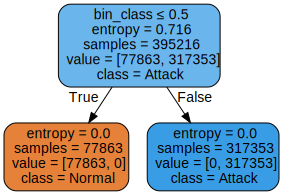

In [121]:
#2
bin_dataset = pnd.read_csv('./kdd_v2.csv')

bin_dataset = bin_dataset.drop(columns=['class', 'class_no_dot', 'attack'])

print ("Transforming data")
t=init_chrono()
bin_dataset.describe
# Categorize columns: "protocol", "service", "flag", "attack_type"
bin_dataset['protocol_type'], protocols= pnd.factorize(bin_dataset['protocol_type'])
bin_dataset['service'], services = pnd.factorize(bin_dataset['service'])
bin_dataset['flag'], flags    = pnd.factorize(bin_dataset['flag'])
bin_dataset['bin_class'], bin_class = pnd.factorize(bin_dataset['bin_class'])
elapsed_time(t)

labels_bin = bin_dataset.iloc[:,bin_dataset.shape[1]-1:]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(bin_dataset, labels_bin, train_size=0.8, test_size=0.2)
print ("X_train, y_train:", X_train_bin.shape, y_train_bin.shape)
print ("X_test, y_test:", X_test_bin.shape, y_test_bin.shape)

t= init_chrono()
clf_bin = DecisionTreeClassifier(criterion='entropy', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             random_state=None,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             class_weight=None,
                             presort=False)
print("Training model with depth : None")
trained_modelbin = clf_bin.fit(X_train_bin, y_train_bin)
elapsed_time(t)
#pdf :D
dot_data = tr.export_graphviz(trained_modelbin, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("kdd_decision_tree_modelbinary", view=True)
dot_data = tr.export_graphviz(trained_modelbin, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("kdd_decision_tree_model_binary_class", view=True)
dot_data = tr.export_graphviz(trained_modelbin, out_file=None, 
                         feature_names = bin_dataset.columns[:len(bin_dataset.columns)],  
                         class_names = bin_class,  
                         filled=True, rounded = True, 
                             special_characters = True)  
graph = graphviz.Source(dot_data)  
graph.render("kdd_decision_tree_model_binary_class_names", view=True)
graph 

In [96]:
#3 isolate file reading to reduce overhead
fds = pnd.read_csv('./kdd_v2.csv')


In [110]:
#fds[fds.class_no_dot == 'probe']
fdst = fds[fds.attack.isin(['normal', 'probe', 'dos', 'u2r'])]
fdst.shape

(492895, 48)

Transforming data
Elapsed time 0:00:00.106142
X_train, y_train: (394316, 45) (394316, 1)
X_test, y_test: (98579, 45) (98579, 1)
Training model with depth : None
Elapsed time 0:00:01.172254


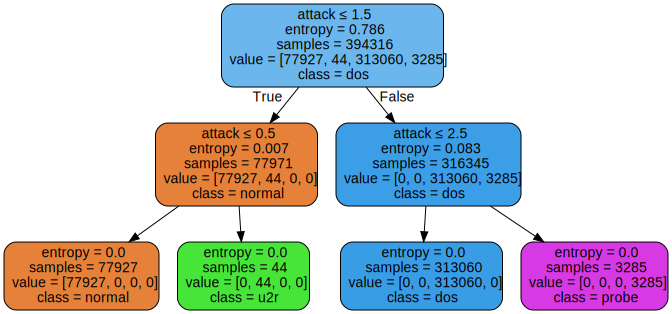

In [119]:

fds = fdst.drop(columns=['class', 'class_no_dot', 'bin_class'])
print ("Transforming data")
t=init_chrono()
# Categorize columns: "protocol", "service", "flag", "attack_type"
fds['protocol_type'], protocols= pnd.factorize(fds['protocol_type'])
fds['service'], services = pnd.factorize(fds['service'])
fds['flag'], flags    = pnd.factorize(fds['flag'])
fds['attack'], fds_attacks = pnd.factorize(fds['attack'])
elapsed_time(t)

labels_fds = fds.iloc[:,fds.shape[1]-1:]

X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(fds, labels_fds, train_size=0.8, test_size=0.2)
print ("X_train, y_train:", X_train_fds.shape, y_train_fds.shape)
print ("X_test, y_test:", X_test_fds.shape, y_test_fds.shape)

t= init_chrono()
clf_fds = DecisionTreeClassifier(criterion='entropy', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             random_state=None,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             class_weight=None,
                             presort=False)
print("Training model with depth : None")
trained_modelfds = clf_fds.fit(X_train_fds, y_train_fds)
elapsed_time(t)
#pdf :D
dot_data = tr.export_graphviz(trained_modelfds, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("kdd_decision_tree_model_four_attacks", view=True)
dot_data = tr.export_graphviz(trained_modelfds, out_file=None, 
                         feature_names = fds.columns[:len(fds.columns)],  
                         class_names = fds_attacks,  
                         filled=True, rounded = True, 
                             special_characters = True)  
graph = graphviz.Source(dot_data)  
graph.render("kdd_decision_tree_model_four_attacks_names", view=True)
graph 

In [ ]:
#our tree

## Deadline: Nov 23th 8 p.m.

 <hr>
Copyright &copy; Oct-2018 Dr.Amir Esseghir